In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))

import numpy as np
from matplotlib import pyplot as plt
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import lagrange
from dg_maxwell import wave_equation as w1d
from dg_maxwell import utils

af.set_backend('opencl')
af.set_device(1)
af.info()

plt.rcParams['figure.figsize']     = 12, 7.5
plt.rcParams['lines.linewidth']    = 1.5
plt.rcParams['font.family']        = 'serif'
plt.rcParams['font.weight']        = 'bold'
plt.rcParams['font.size']          = 20  
plt.rcParams['font.sans-serif']    = 'serif'
plt.rcParams['text.usetex']        = True
plt.rcParams['axes.linewidth']     = 1.5
plt.rcParams['axes.titlesize']     = 'medium'
plt.rcParams['axes.labelsize']     = 'medium'

plt.rcParams['xtick.major.size']   = 8
plt.rcParams['xtick.minor.size']   = 4
plt.rcParams['xtick.major.pad']    = 8
plt.rcParams['xtick.minor.pad']    = 8
plt.rcParams['xtick.color']        = 'k'
plt.rcParams['xtick.labelsize']    = 'medium'
plt.rcParams['xtick.direction']    = 'in'    

plt.rcParams['ytick.major.size']   = 8
plt.rcParams['ytick.minor.size']   = 4
plt.rcParams['ytick.major.pad']    = 8
plt.rcParams['ytick.minor.pad']    = 8
plt.rcParams['ytick.color']        = 'k'
plt.rcParams['ytick.labelsize']    = 'medium'
plt.rcParams['ytick.direction']    = 'in'
plt.rcParams['text.usetex']        = True
plt.rcParams['text.latex.unicode'] = True

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [2]:
# 1. Set the initial conditions

E_00 = 1.
E_01 = 1.

B_00 = 0.2
B_01 = 0.5

E_z_init = E_00 * af.sin(2 * np.pi * params.element_LGL) \
         + E_01 * af.cos(2 * np.pi * params.element_LGL)

B_y_init = B_00 * af.sin(2 * np.pi * params.element_LGL) \
         + B_01 * af.cos(2 * np.pi * params.element_LGL)

u_init = af.constant(0., d0 = params.N_LGL, d1 = params.N_Elements, d2 = 2)
u_init[:, :, 0] = E_z_init
u_init[:, :, 1] = E_z_init

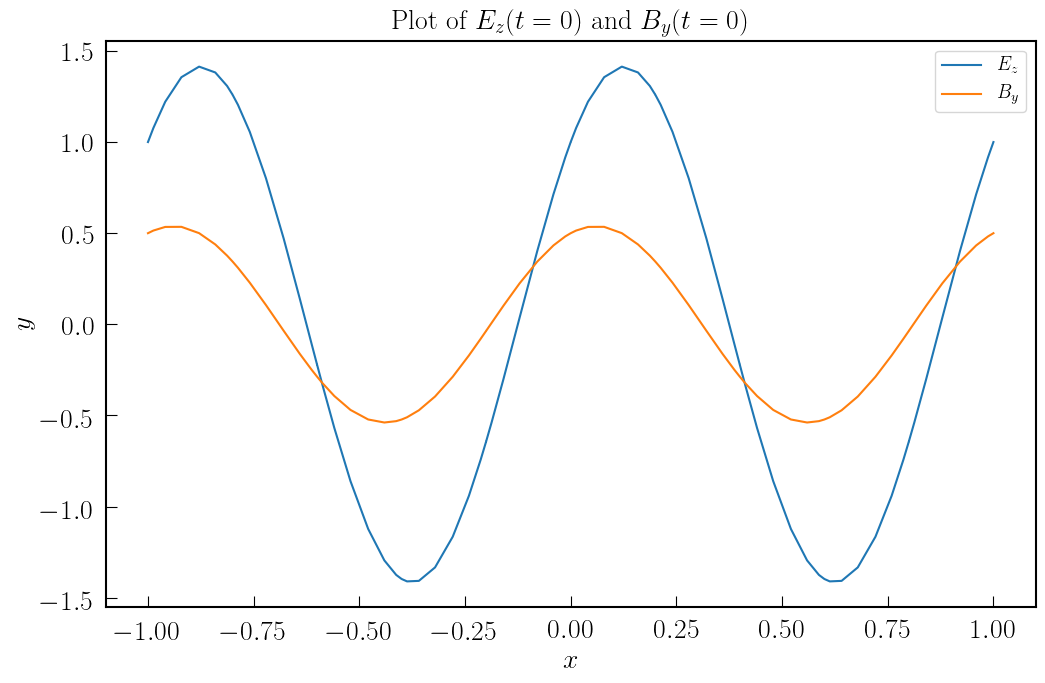

In [3]:
element_LGL_flat = af.flat(params.element_LGL)
E_z_init_flat    = af.flat(u_init[:, :, 0])
B_y_init_flat    = af.flat(u_init[:, :, 1])

plt.plot(element_LGL_flat, E_z_init_flat, label = r'$E_z$')
plt.plot(element_LGL_flat, B_y_init_flat, label = r'$B_y$')

plt.title(r'Plot of $E_z(t = 0)$ and $B_y(t = 0)$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.legend(prop={'size': 14})

plt.show()

# Formal implementation of volume integral flux for multiple-u's

In [41]:
# 2. Check if the volume term works for multiple u's.

u_n = u_init[:, :, :].copy()


shape_u_n = utils.shape(u_n)
# The coefficients of dLp / d\xi
diff_lag_coeff  = params.dl_dxi_coeffs

lobatto_nodes   = params.lobatto_quadrature_nodes
Lobatto_weights = params.lobatto_weights_quadrature

nodes_tile   = af.transpose(af.tile(lobatto_nodes, 1, diff_lag_coeff.shape[1]))
power        = af.flip(af.range(diff_lag_coeff.shape[1]))
power_tile   = af.tile(power, 1, params.N_quad)
nodes_power  = nodes_tile ** power_tile
weights_tile = af.transpose(af.tile(Lobatto_weights, 1, diff_lag_coeff.shape[1]))
nodes_weight = nodes_power * weights_tile

dLp_dxi      = af.matmul(diff_lag_coeff, nodes_weight)


# The first option to calculate the volume integral term, directly uses
# the Lobatto quadrature instead of using the integrate() function by
# passing the coefficients of the Lagrange interpolated polynomial.
if(params.volume_integral_scheme == 'lobatto_quadrature' \
    and params.N_quad == params.N_LGL):

    # Flux using u_n, reordered to 1 X N_LGL X N_Elements array.
    F_u_n                  = af.reorder(w1d.flux_x(u_n), 3, 0, 1, 2)
    F_u_n = af.tile(F_u_n, d0 = params.N_LGL)

    # Multiplying with dLp / d\xi
    integral_expansion     = af.broadcast(utils.multiply,
                                          dLp_dxi, F_u_n)

#     # Using the quadrature rule.
    flux_integral = af.sum(integral_expansion, 1)

    flux_integral = af.reorder(flux_integral, 0, 2, 3, 1)

# Using the integrate() function to calculate the volume integral term
# by passing the Lagrange interpolated polynomial.
else:
    print('option3')
    analytical_flux_coeffs = af.transpose(af.moddims(u_n,
                                                     d0 = params.N_LGL,
                                                     d1 = params.N_Elements * shape_u_n[2]))
    
    analytical_flux_coeffs = w1d.flux_x(lagrange.lagrange_interpolation(analytical_flux_coeffs))
    analytical_flux_coeffs = af.transpose(af.moddims(af.transpose(analytical_flux_coeffs),
                                                     d0 = params.N_LGL, d1 = params.N_Elements,
                                                     d2 = shape_u_n[2]))
    
    analytical_flux_coeffs = af.reorder(analytical_flux_coeffs, d0 = 3, d1 = 1, d2 = 0, d3 = 2)
    analytical_flux_coeffs = af.tile(analytical_flux_coeffs, d0 = params.N_LGL)
    analytical_flux_coeffs = af.moddims(af.transpose(analytical_flux_coeffs), d0 = params.N_LGL,
                                        d1 = params.N_LGL * params.N_Elements, d2 = 1,
                                        d3 = shape_u_n[2])
    analytical_flux_coeffs = af.moddims(analytical_flux_coeffs, d0 = params.N_LGL,
                                        d1 = params.N_LGL * params.N_Elements * shape_u_n[2],
                                        d2 = 1,
                                        d3 = 1)
    analytical_flux_coeffs = af.transpose(analytical_flux_coeffs)

    dl_dxi_coefficients    = af.tile(af.tile(params.dl_dxi_coeffs, d0 = params.N_Elements), d0 = shape_u_n[2])

    volume_int_coeffs = utils.poly1d_product(dl_dxi_coefficients,
                                             analytical_flux_coeffs)
    
    flux_integral = lagrange.integrate(volume_int_coeffs)
    flux_integral = af.moddims(af.transpose(flux_integral), d0 = params.N_LGL,
                               d1 = params.N_Elements,
                               d2 = shape_u_n[2])

#     flux_integral = af.moddims(flux_integral, params.N_LGL, params.N_Elements)

flux_integral_test = flux_integral.copy()

option3


# Testing

In [42]:
u_n = u_init[:, :, 0].copy()

flux_integral_ref = w1d.volume_integral_flux(u_n)

In [43]:
print(af.all_true(af.abs(flux_integral_ref - flux_integral_test[:, :, 0]) < 1e-13))

1.0


# Miscellaneous tests for the modules

In [40]:
foo = af.moddims(af.range(params.N_LGL * params.N_Elements), d0 = params.N_LGL, d1 = params.N_Elements)
foo = af.tile(foo, d0 = 1, d1 = 1, d2 = 2)

# print(foo)

foo_elements_joined = af.transpose(af.moddims(foo, d0 = params.N_LGL,
                                              d1 = params.N_Elements * foo.shape[2]))

# print(foo_elements_joined)

foo_interpolate = lagrange.lagrange_interpolation(foo_elements_joined)
foo_interpolate_elements_separate = af.transpose(af.moddims(af.transpose(foo_interpolate), d0 = params.N_LGL,
                                                            d1 = params.N_Elements, d2 = foo.shape[2]))

# print(foo_interpolate_elements_separate)

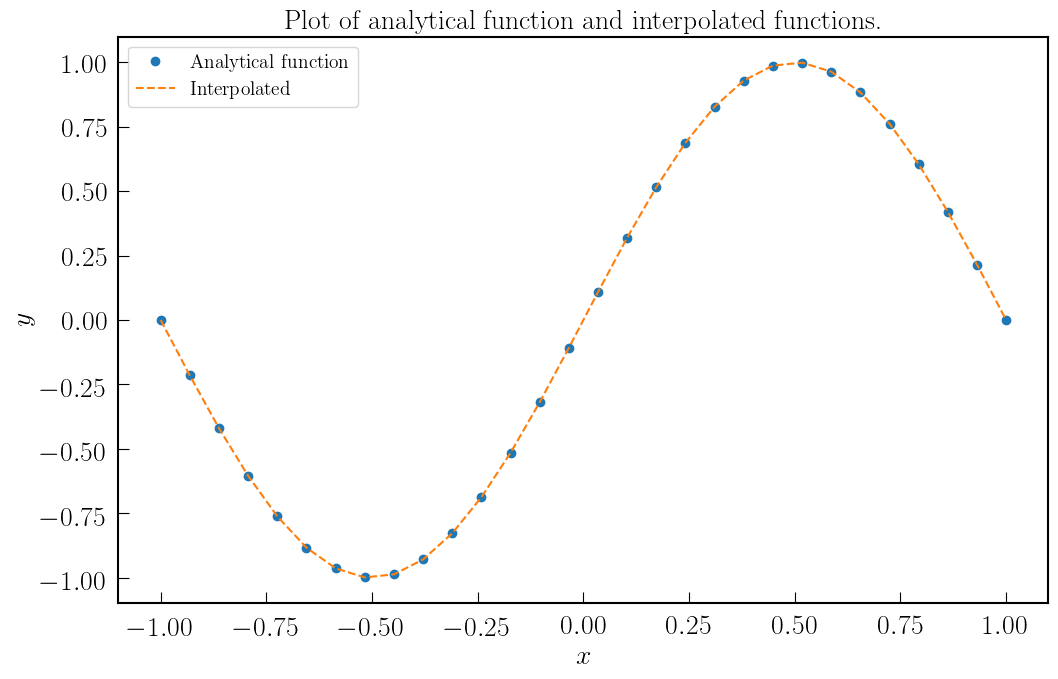

In [3]:
def function(xi):
    return af.sin(np.pi * xi)

# Test lagrange interpolation

f_i = function(params.xi_LGL)
fn_i = af.transpose(af.tile(f_i, d0 = 1, d1 = 1))

lagrange_interpolation = lagrange.lagrange_interpolation(fn_i)

# Testing

xi_linsp = utils.linspace(-1, 1, 30)
function_analytical = function(xi_linsp)

function_interpolated_xi_linsp = utils.polyval_1d(lagrange_interpolation, xi_linsp)

plt.plot(np.array(xi_linsp), np.array(function_analytical), 'o', label = 'Analytical function')
plt.plot(np.array(xi_linsp), np.array(af.transpose(function_interpolated_xi_linsp[0])), '--',
         label = 'Interpolated')

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Plot of analytical function and interpolated functions.')
plt.legend(prop={'size': 14})
plt.show()